In [23]:
import random
import matplotlib.pyplot as plt
import time

# problem instance
N = 16 # number of queens (size of the problem)
MAX_CONFLICTS = N * (N - 1) * 0.5 # max number of conflicts in N-queens problem
seed=1234

In [24]:
class Individual:
    def __init__(self, positions):
        self.positions = positions

    def __str__(self):
        return repr(self.positions)

    def fitness(self):
        n_conflicts = 0
        n = len(self.positions)
        for i in range(n):
            for j in range(i + 1, n):
                if self.positions[i] == self.positions[j] or abs(self.positions[i] - self.positions[j]) == j - i:
                    n_conflicts += 1
        return MAX_CONFLICTS - n_conflicts

    def is_solution(self):
        if self.fitness() == MAX_CONFLICTS:
            return 1
        return 0

In [25]:
class GA:
    def __init__(self, population_size, selection_type, crossover_type, crossover_rate, mutation_rate, max_generations):
        self.population = []
        self.population_size = population_size
        self.selection_type = selection_type
        self.crossover_type = crossover_type
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.max_generations = max_generations
        self.new_gen = 1
        # for roulette selection
        self.tot_fitness = []
        self.norm_fitness = []
        self.cum_fitness = []

    def initialize_population(self):
        init_pop = []
        for _ in range(self.population_size):
            positions = random.sample(range(N),N)
            individual = Individual(positions)
            init_pop.append(individual)
        self.population = init_pop

    # return a list of selected individuals
    def selection(self):
        if self.selection_type == 'tournament':
            return self._tournament()
        if self.selection_type == 'roulette':
            return self._roulette()

    def _tournament(self):
        candidates = random.sample(self.population, k=5)
        fittest = max(candidates, key=lambda c: c.fitness())
        return fittest.positions

    def _roulette(self):
        if self.new_gen == 1:
            self.tot_fitness = sum([i.fitness() for i in self.population])
            self.norm_fitness = [i.fitness()/self.tot_fitness for i in self.population]
            self.cum_fitness = [sum(self.norm_fitness[:i+1]) for i in range(len(self.norm_fitness))]

        p = random.random()
        chosen = []
        for i in range(len(self.cum_fitness)):
            if p <= self.cum_fitness[i]:
                chosen = self.population[i].positions
                break
        return chosen

    # single and double are two additional crossover operations one can use
    def crossover(self, parent1, parent2):
        if self.crossover_type == 'single':
          return self._single_point(parent1,parent2)
        if self.crossover_type == 'double':
          return self._double_point(parent1,parent2)
        if self.crossover_type == 'ox':
          return self._ox(parent1,parent2)

    def _ox(self, parent1, parent2):
        child1, child2 = parent1.copy(), parent2.copy()
        if random.random() < self.crossover_rate:
            c_point1, c_point2 = random.sample(range(N),2)
            if c_point1 > c_point2:
                c_point1, c_point2 = c_point2, c_point1

            child1, child2 = [N]*N, [N]*N
            sub1 = list(parent1[c_point1:c_point2+1])
            rest1 = []
            for p in parent2:
                if p not in sub1:
                    rest1.append(p)

            for i in range(N):
                if i < c_point1 or i > c_point2:
                    child1[i] = rest1.pop(0)
                else:
                    child1[i] = sub1.pop(0)

            sub2 = list(parent2[c_point1:c_point2+1])
            rest2 = []
            for p in parent1:
                if p not in sub2:
                    rest2.append(p)

            for i in range(N):
                if i < c_point1 or i > c_point2:
                    child2[i] = rest2.pop(0)
                else:
                    child2[i] = sub2.pop(0)

        return child1,child2


    def _single_point(self, parent1, parent2):
        child1, child2 = parent1.copy(), parent2.copy()
        if random.random() < self.crossover_rate:
            c_point= random.randint(1,N-2)
            child1 = parent1[:c_point] + parent2[c_point:]
            child2 = parent2[:c_point] + parent1[c_point:]
        return child1, child2

    def _double_point(self, parent1, parent2):
        child1, child2 = parent1.copy(), parent2.copy()
        if random.random() < self.crossover_rate:
            c_point1= random.randint(1,N-3)
            c_point2= random.randint(c_point1+1, N-2)
            child1 = parent1[:c_point1] + parent2[c_point1:c_point2] + parent1[c_point2:]
            child2 = parent2[:c_point1] + parent1[c_point1:c_point2] + parent2[c_point2:]
        return child1, child2

    # swap mutation
    def mutate(self, positions):
        if random.random() < self.mutation_rate:
            p1, p2 = random.sample(range(N),2)
            positions[p1], positions[p2] = positions[p2], positions[p1]
        return positions

    def avg_fitness(self):
        cum_fitness = 0
        for individual in self.population:
            cum_fitness = cum_fitness + individual.fitness()
        return cum_fitness / len(self.population)

    def next_generation(self):
        new_population = []
        while len(new_population) < len(self.population):
            parent1 = self.selection()
            parent2 = self.selection()
            self.new_gen = 0 # to avoid recomputing the vectors for roulette selection

            child1, child2 = self.crossover(parent1,parent2)

            child1 = self.mutate(child1)
            child2 = self.mutate(child2)

            new_population.append(Individual(child1))
            new_population.append(Individual(child2))

        self.population = new_population
        self.new_gen = 1
        return new_population

    def start_search(self):
        self.initialize_population()
        avg_fitnesses = []
        best_fitnesses = []
        best_individual = Individual([0]*N)
        start = time.time()
        best_individual = max(self.population, key=lambda c: c.fitness())
        iteration_best_individual = 0
        # best individual already in the initial population, return
        if best_individual.fitness() == MAX_CONFLICTS:
          return [],[],best_individual,iteration_best_individual
        for generation in range(self.max_generations):
            # compute next generation
            self.next_generation()
            # get best individual of current generation
            curr_gen_best_individual = max(self.population, key=lambda c: c.fitness())
            avg_fitness = self.avg_fitness()
            avg_fitnesses.append(avg_fitness)
            best_fitnesses.append(best_individual.fitness())
            # compute the cumulative execution time for this generation
            gen_exec_time = time.time() - start
            # print some info about current generation
            #print(f"generation {generation+1}, n_conflicts = {MAX_CONFLICTS - curr_gen_best_individual.fitness()}, avg_fitness= {avg_fitness}, total exec time= {gen_exec_time}")
            print("generation {}, n_conflicts= {:.0f}, avg_fitness= {:.2f}, total exec time= {:.2f}".format(generation+1,MAX_CONFLICTS - curr_gen_best_individual.fitness(),avg_fitness,gen_exec_time))
            # if current best individual is better than all time best individual, replace it
            if curr_gen_best_individual.fitness() > best_individual.fitness():
              best_individual = curr_gen_best_individual
              iteration_best_individual = generation + 1
              # recheck if this new best individual is a solution
              # (comment this if for the tuning plot)
              if best_individual.fitness() == MAX_CONFLICTS:
                break
        return avg_fitnesses, best_fitnesses, best_individual, iteration_best_individual

In [26]:
class SearchParams:

    def __init__(self,avg_fitnesses,best_fitnesses,best_individual,ps,cr,mr):
        self.avg_fitnesses = avg_fitnesses
        self.best_fitnesses = best_fitnesses
        self.best_individual = best_individual
        self.ps = ps
        self.cr = cr
        self.mr = mr

In [27]:
# tuning of the parameters of the GA
def tuning():
    population_size = [50,100,150]
    crossover_rate = [0.5,0.7,0.9]
    mutation_rate = [0.01,0.02,0.05]

    # fixed
    mg = 20
    st = 'tournament'
    ct = 'ox'

    searches = []
    for ps in population_size:
        for cr in crossover_rate:
            for mr in mutation_rate:
                random.seed(seed)
                ga = GA(ps,st,ct,cr,mr,mg)
                avg_fitnesses, best_fitnesses, best_individual, iteration_best_individual = ga.start_search()
                sp = SearchParams(avg_fitnesses,best_fitnesses,best_individual,ps,cr,mr)
                searches.append(sp)
    return searches

In [28]:
def plot_avg_fitness_curves():
    searches = tuning()
    searches_sorted = sorted(searches, key=lambda x: x.best_individual.fitness(), reverse=True) [:5]

    for s in searches_sorted:
        print("individual= {}, n_conflicts= {}".format(s.best_individual,MAX_CONFLICTS-s.best_individual.fitness()))
        plt.plot(s.avg_fitnesses, label="ps= {}, cr= {}, mr= {}".format(s.ps,s.cr,s.mr))
    plt.title("Avg fitness curves for {}-queens problem".format(N))
    plt.xlabel("Generation")
    plt.ylabel("Avg fitness")
    plt.legend(loc='lower right',prop={'size': 8})
    plt.show()

generation 1, n_conflicts = 4.0,avg_fitness= 112.5,total exec time= 0.03467679023742676
generation 2, n_conflicts = 5.0,avg_fitness= 112.7,total exec time= 0.052190542221069336
generation 3, n_conflicts = 5.0,avg_fitness= 114.34,total exec time= 0.07179999351501465
generation 4, n_conflicts = 5.0,avg_fitness= 113.86,total exec time= 0.08772540092468262
generation 5, n_conflicts = 5.0,avg_fitness= 113.54,total exec time= 0.10215473175048828
generation 6, n_conflicts = 5.0,avg_fitness= 114.14,total exec time= 0.11594367027282715
generation 7, n_conflicts = 4.0,avg_fitness= 113.94,total exec time= 0.12951087951660156
generation 8, n_conflicts = 4.0,avg_fitness= 114.46,total exec time= 0.15123677253723145
generation 9, n_conflicts = 4.0,avg_fitness= 113.94,total exec time= 0.16823720932006836
generation 10, n_conflicts = 4.0,avg_fitness= 114.36,total exec time= 0.18804097175598145
generation 11, n_conflicts = 4.0,avg_fitness= 115.92,total exec time= 0.21220874786376953
generation 12, n_con

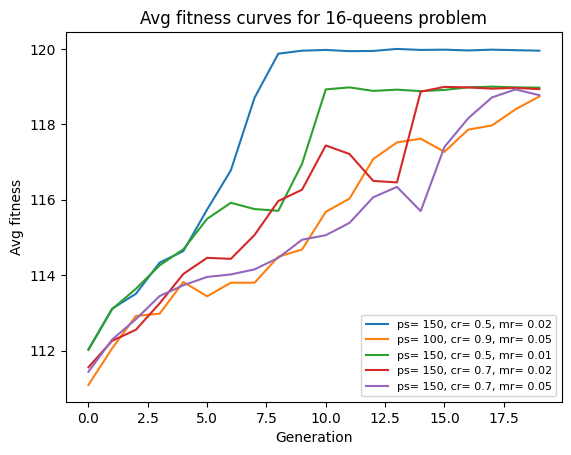

In [108]:
# to show proper results don't break the loop when zero conflicts are found (see GA.start_search())
#plot_avg_fitness_curves()

In [29]:
# solving the N-queens problem
pop_size = 1000
st = 'tournament'
ct = 'ox'
cr = 0.7
mr = 0.2
mg = 150

random.seed(seed)
ga = GA(pop_size,st,ct,cr,mr,mg)
avg_fitnesses, best_fitnesses, best_individual, iteration_best_individual = ga.start_search()
print("Best solution:",best_individual, "n_conflicts= {}".format(MAX_CONFLICTS-best_individual.fitness()), "iteration= {}".format(iteration_best_individual))

generation 1, n_conflicts= 4, avg_fitness= 112.03, total exec time= 0.06
generation 2, n_conflicts= 3, avg_fitness= 113.11, total exec time= 0.10
generation 3, n_conflicts= 2, avg_fitness= 113.51, total exec time= 0.14
generation 4, n_conflicts= 0, avg_fitness= 114.33, total exec time= 0.18
Best solution: [13, 5, 12, 1, 4, 6, 11, 2, 10, 3, 0, 8, 15, 9, 7, 14] n_conflicts= 0.0 iteration= 4
